Goal: Goal: Train and test a Random Forest Regression model using features: Bednights, Region, HHSize, HHEmployed, HHTANF, and slotted along with group: FamilyID to be able to predict bednights. Evaluate and iterate model. Second attempt at modeling after Linear Regression.

In [1]:
##Load Modules for Roandom Forest Regression Analysis training and testing
import pandas as pd
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

In [2]:
##Load data, already processed to show no duplicates and no NaN in Linear Model, won't be repeated here
##Forest Regressor handles one-hot encoding natively, won't repeat pd.get_dummies here.
## descriptive statistics handled previously in Linear Regression. .describe() not repeated here.
forest1 = pd.read_csv("C:/Users/morel/Downloads/Model_Training_Data.csv")
print(forest1.head(5))

   FamilyID  ResidentID  Bednights  RegionCode  HHSize  HHEmployed  HHTANF  \
0       243         957        957           1       4           1       0   
1       243         958        957           1       4           1       0   
2       243         959        957           1       4           1       0   
3       243         960        957           1       4           1       0   
4       242         973        944           1       3           1       0   

   Slotted  
0        0  
1        0  
2        0  
3        0  
4        1  


In [3]:
##Forest Regression: predict bednights. Clean data - ensure correct dtypes.
forest1 = forest1.astype({'RegionCode':'category','HHEmployed':'int64','HHTANF':'int64','Slotted':'int64'})
print(forest1.dtypes)

FamilyID         int64
ResidentID       int64
Bednights        int64
RegionCode    category
HHSize           int64
HHEmployed       int64
HHTANF           int64
Slotted          int64
dtype: object


In [4]:
##Forest Regression: predict bednights. Prepare features, (automatically) identify categorical and numeric columns for Forest Regression Pipeline
x = forest1.drop(columns=['Bednights','FamilyID','ResidentID']) 
y = forest1['Bednights']                                       
groups = forest1['FamilyID']

categorical_cols = x.select_dtypes(include=['object','category']).columns.tolist()
numerical_cols = x.select_dtypes(include=['int64','float64']).columns.tolist()

In [5]:
##Forest Regression: predict bednights. Preprocess pipelines for each column type - set up dummies.
preprocessor = ColumnTransformer(transformers=[
    ('num','passthrough',numerical_cols),
    ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_cols)
])

In [6]:
##Forest Regression: predict bednights. build pipeline - set up to transform data and train the model reproducibly
##use n_estimators to show tree
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model',RandomForestRegressor(random_state=42, n_estimators=10))
])

num__HHSize: 0.3767
num__HHEmployed: 0.3419
num__HHTANF: 0.0332
num__Slotted: 0.0669
cat__RegionCode_1: 0.0331
cat__RegionCode_2: 0.0757
cat__RegionCode_3: 0.0194
cat__RegionCode_4: 0.0531
cat__RegionCode_5: 0.0001


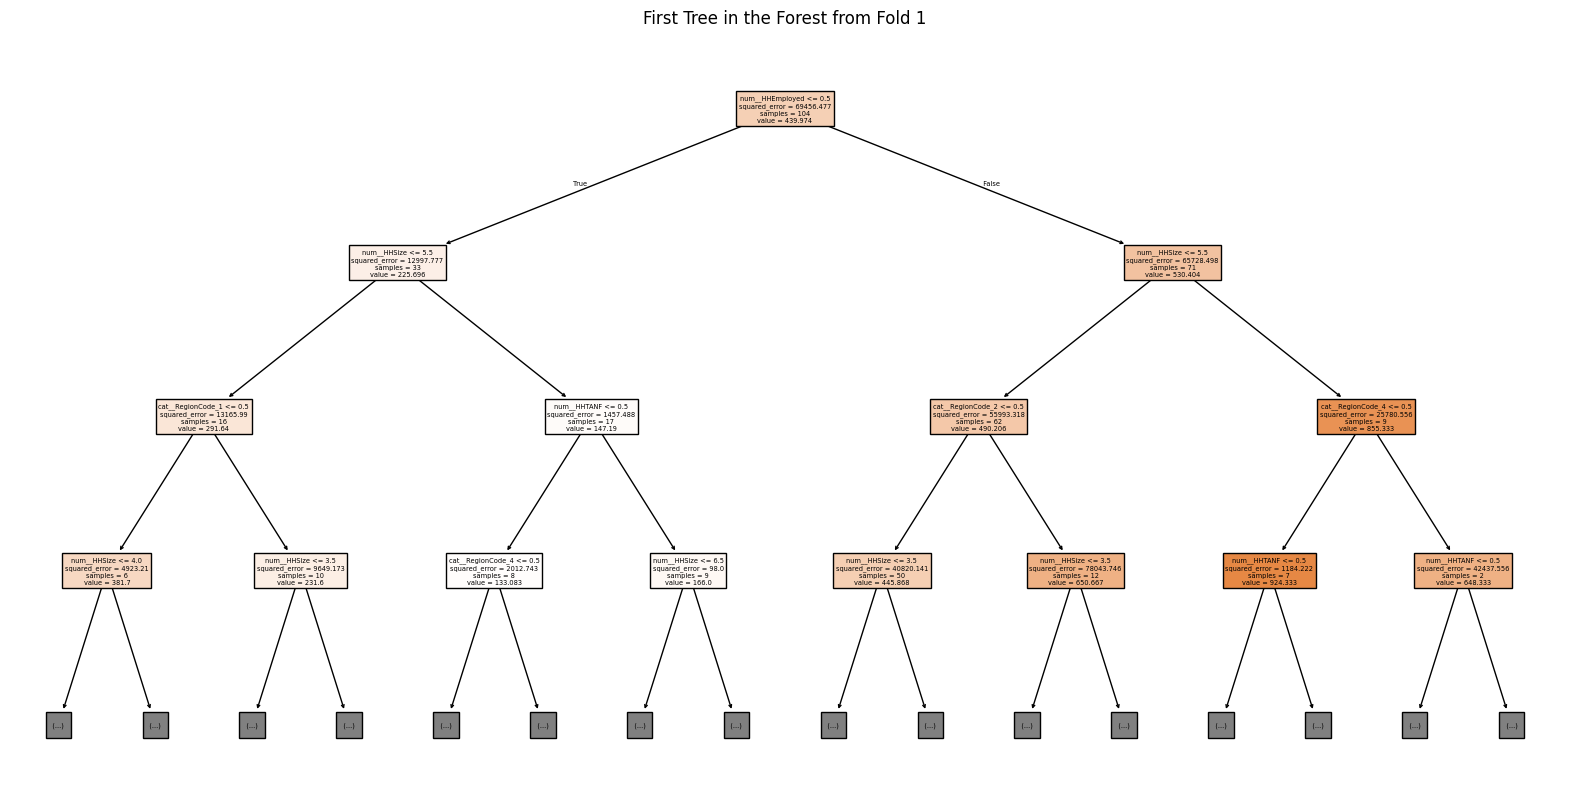

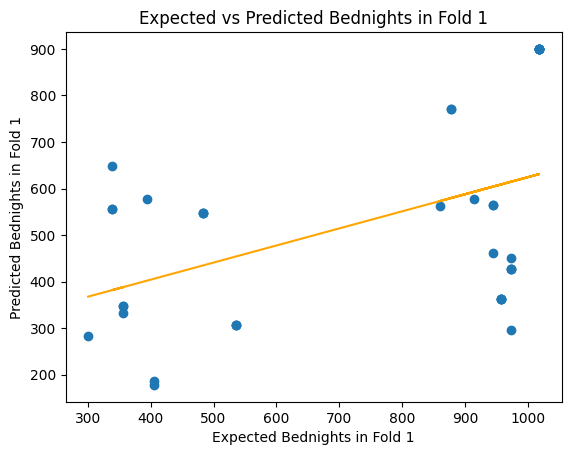

Fold 1 - MSE: 112282.1062, RMSE: 335.0852, R^2: -0.4673
num__HHSize: 0.3644
num__HHEmployed: 0.3345
num__HHTANF: 0.0841
num__Slotted: 0.0650
cat__RegionCode_1: 0.0350
cat__RegionCode_2: 0.0312
cat__RegionCode_3: 0.0137
cat__RegionCode_4: 0.0632
cat__RegionCode_5: 0.0089


<Figure size 640x480 with 0 Axes>

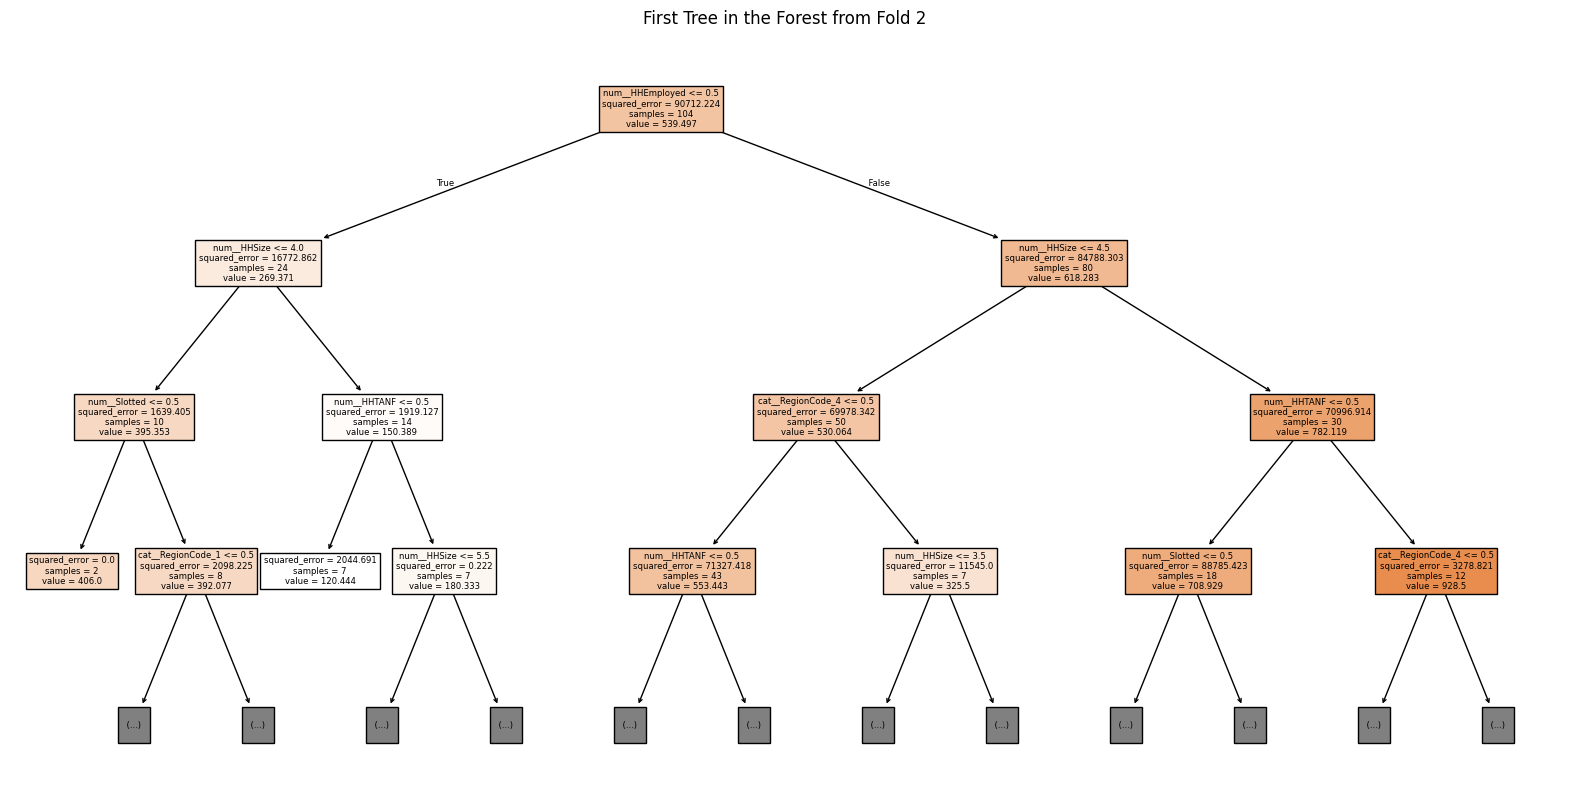

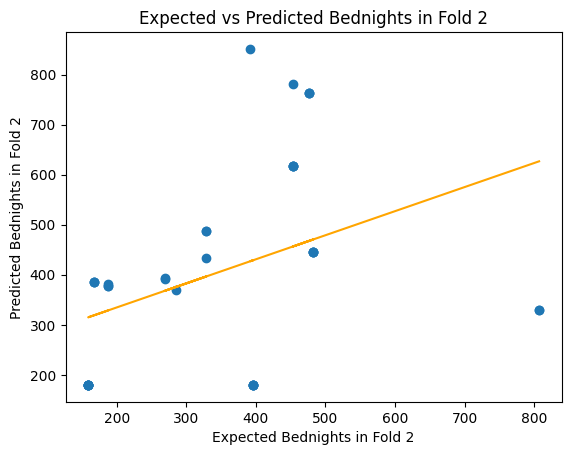

Fold 2 - MSE: 44029.8765, RMSE: 209.8330, R^2: -0.6289
num__HHSize: 0.3909
num__HHEmployed: 0.3488
num__HHTANF: 0.0577
num__Slotted: 0.0489
cat__RegionCode_1: 0.0224
cat__RegionCode_2: 0.0054
cat__RegionCode_3: 0.0357
cat__RegionCode_4: 0.0904


<Figure size 640x480 with 0 Axes>

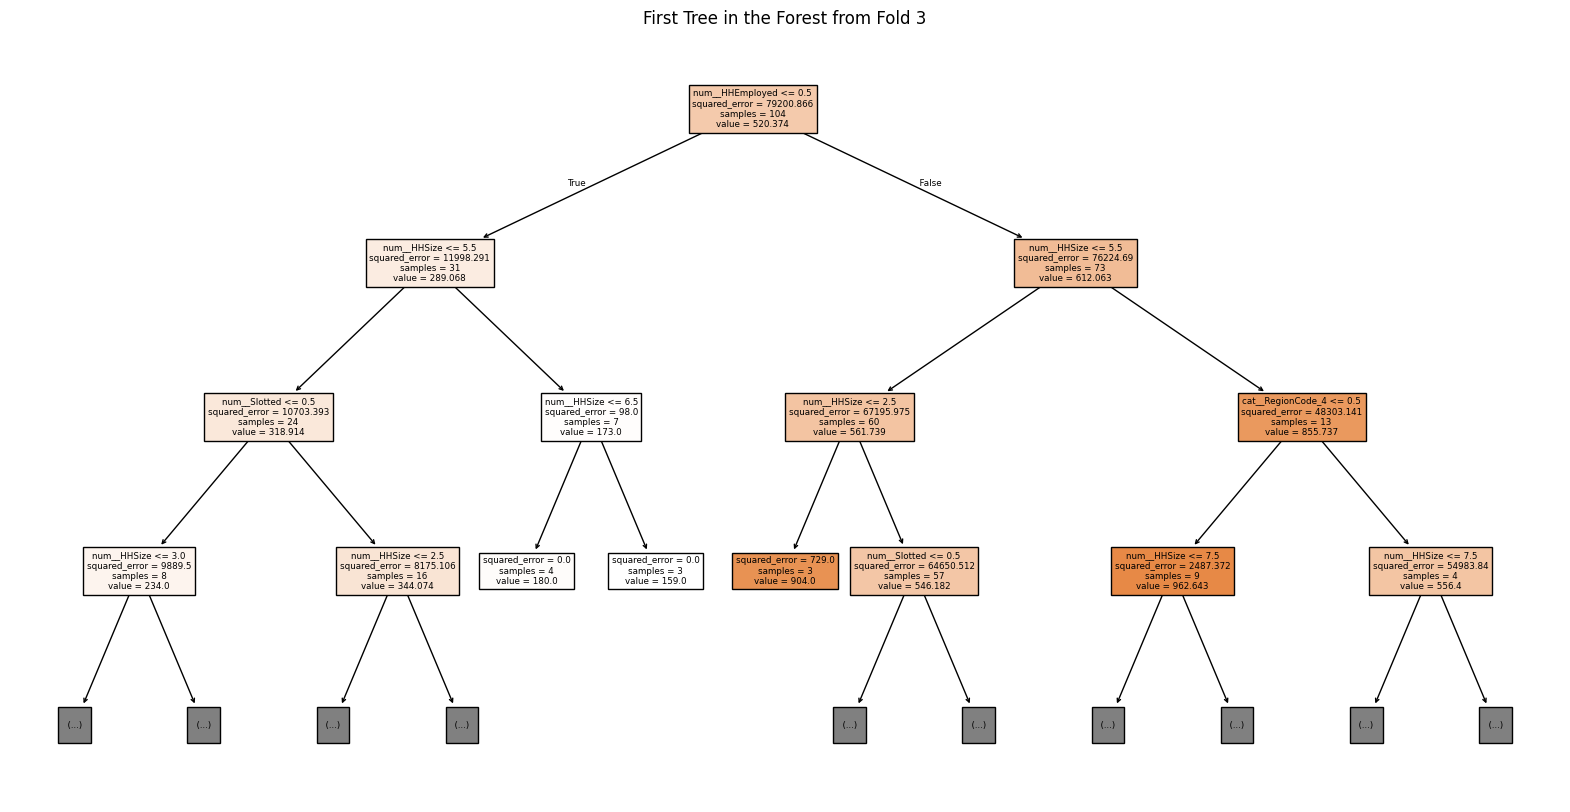

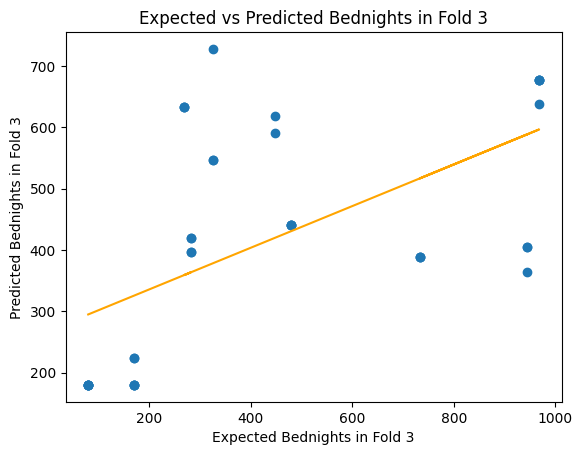

Fold 3 - MSE: 65684.1459, RMSE: 256.2892, R^2: 0.3361
num__HHSize: 0.2761
num__HHEmployed: 0.3531
num__HHTANF: 0.0879
num__Slotted: 0.0917
cat__RegionCode_1: 0.0650
cat__RegionCode_2: 0.0571
cat__RegionCode_3: 0.0159
cat__RegionCode_4: 0.0500
cat__RegionCode_5: 0.0032


<Figure size 640x480 with 0 Axes>

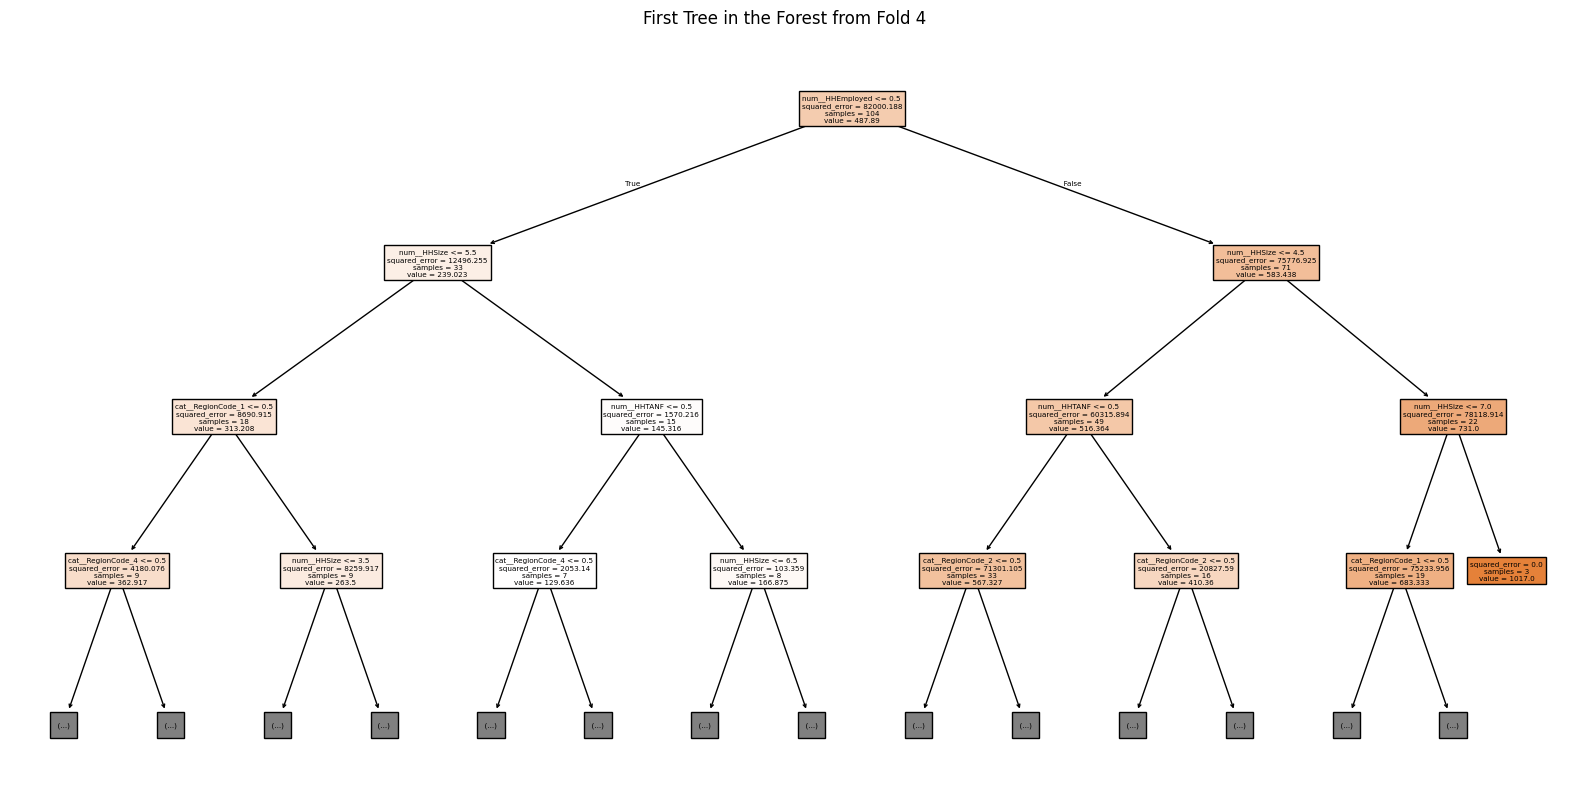

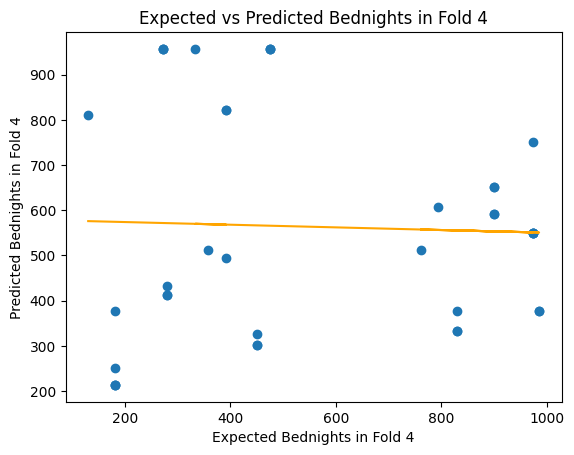

Fold 4 - MSE: 157166.8735, RMSE: 396.4428, R^2: -0.6990
num__HHSize: 0.3175
num__HHEmployed: 0.4622
num__HHTANF: 0.0457
num__Slotted: 0.0417
cat__RegionCode_1: 0.0399
cat__RegionCode_2: 0.0239
cat__RegionCode_3: 0.0267
cat__RegionCode_4: 0.0403
cat__RegionCode_5: 0.0019


<Figure size 640x480 with 0 Axes>

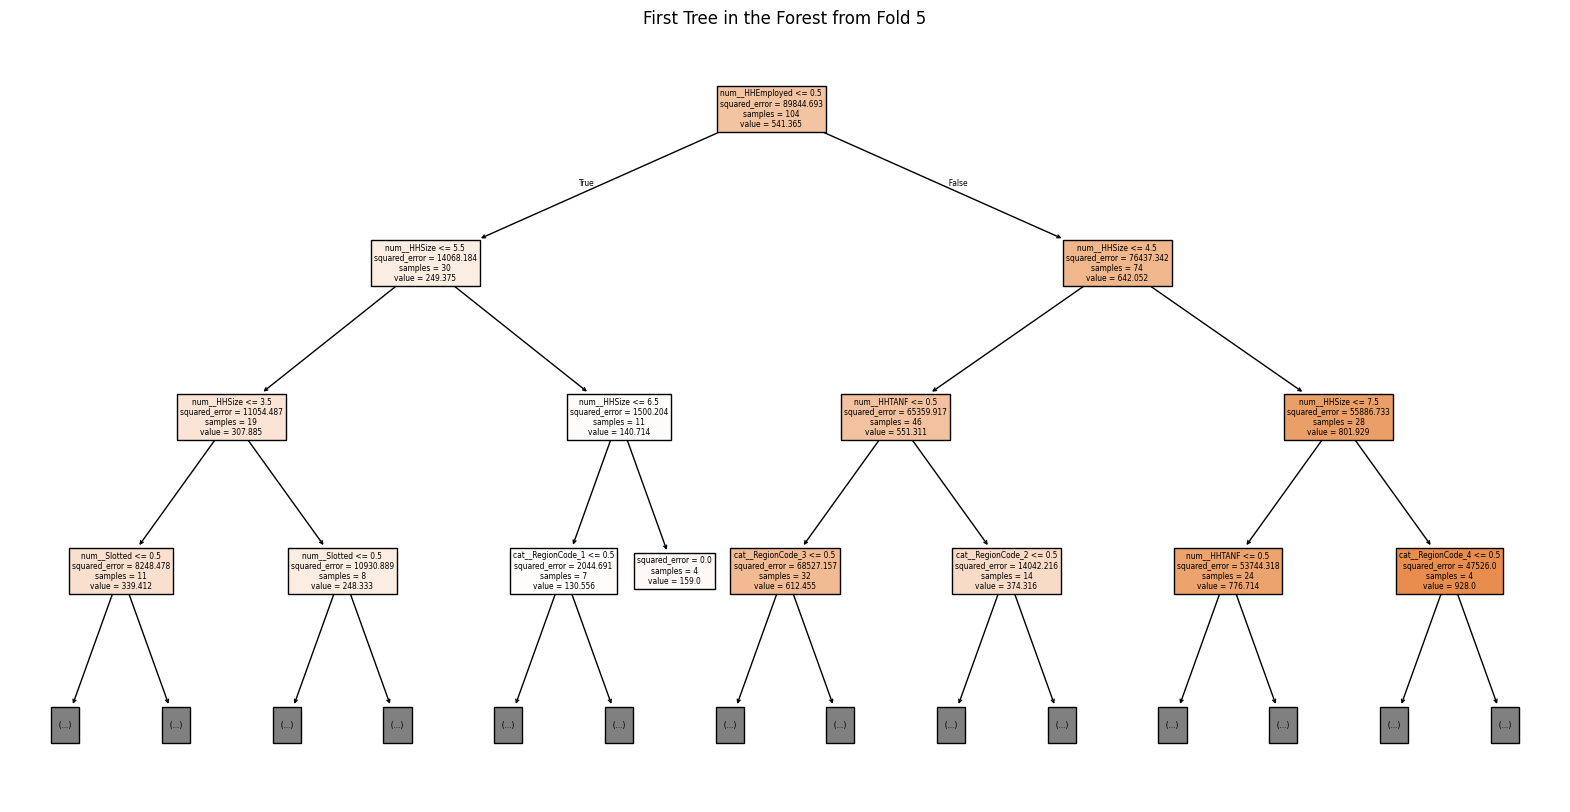

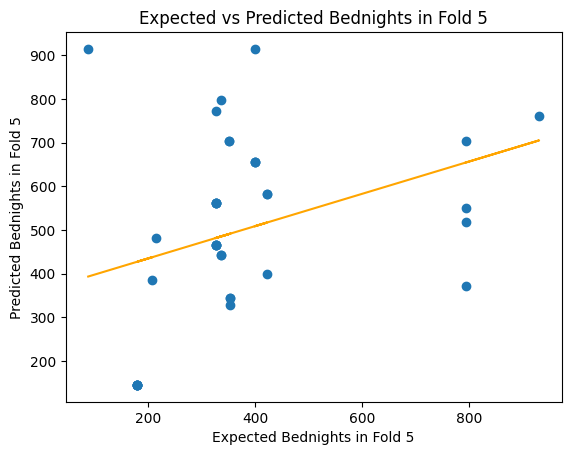

Fold 5 - MSE: 69520.8934, RMSE: 263.6682, R^2: -0.8700


<Figure size 640x480 with 0 Axes>

In [7]:
##Forest Regression: predict bednights. GKF - set up folds for cross validation and to handle autocorrelation
gkf = GroupKFold(n_splits=5)

##Loop through folds to split the data for testing and training, fitting model, show fitness, and evaluate
for fold, (train_idx, test_idx) in enumerate(gkf.split(x, y, groups)):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ##train (pipeline handles transforming data and training the model at the same time and reproducibly, it's coming together in my head)
    ##get estimators and column names to show tree
    ##get importances of each feature to improve model
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    rf_model = pipeline.named_steps['model']
    first_tree = rf_model.estimators_[0]
    feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
    importances = rf_model.feature_importances_
    for name, importance in zip(
        pipeline.named_steps['preprocessing'].get_feature_names_out(), importances):
        print(f'{name}: {importance:.4f}')

    ##show tree
    plt.figure(figsize=(20, 10))
    plot_tree(first_tree,
             feature_names=feature_names,
             filled=True,
             rounded=False,
             max_depth=3)
    plt.title(f'First Tree in the Forest from Fold {fold+1}')
    plt.show()
    plt.clf()

    ##show fitness
    plt.scatter(y_test, y_pred)
    plt.xlabel(f'Expected Bednights in Fold {fold+1}')
    plt.ylabel(f'Predicted Bednights in Fold {fold+1}')
    plt.title(f'Expected vs Predicted Bednights in Fold {fold+1}')
    a, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, a * y_test + b, color='orange')
    plt.show()
    plt.clf()

    ##Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Fold {fold+1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}')

Goal 2: Improve. Random Forest Regression has worse R^2 values than Linear Regression. Retrain using aggregate importances and subset of features to maximize cross-validated r2.

In [15]:
##Improve Forest Regression: predict bednights. initialize variables / lists
gkf = GroupKFold(n_splits=5)
importances_all_folds = []

In [17]:
##Improve Forest Regression: predict bednights. Train multiple models to select features and collect importances
for fold, (train_idx, test_idx) in enumerate(gkf.split(x,y,groups)):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]

    pipeline.fit(x_train, y_train)

    rf = pipeline.named_steps['model']
    importances_all_folds.append(rf.feature_importances_)

importances_all_folds = np.array(importances_all_folds)
print(importances_all_folds)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.